### Environment setting

In [1]:
!pip install mplfinance
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70 kB 9.2 MB/s 
Selecting previously unselected package libta-lib0.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 271 kB 27.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... 

In [2]:
import mplfinance as mpf
import talib
import os
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Load data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir = "/content/drive/MyDrive/FinTech/HW2"
data_path = os.path.join(data_dir, "APPLE.csv")
data_df = pd.read_csv(data_path)

In [6]:
data_df.index = pd.DatetimeIndex(data_df['Date'])
data_df = data_df.drop(columns='Date')

### Q1 : plotting

In [7]:
kd_tuple = talib.STOCH(high=data_df.High, low=data_df.Low, close=data_df.Close)
kd_df = pd.DataFrame(kd_tuple).T.rename(columns={0: "slowk", 1: "slowd"})

In [8]:
kd_line_plot = mpf.make_addplot(kd_df, panel=1, ylabel='KD line')

In [9]:
mc = mpf.make_marketcolors(up='r', down='g', edge='', wick='inherit', volume='inherit')
s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:46: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


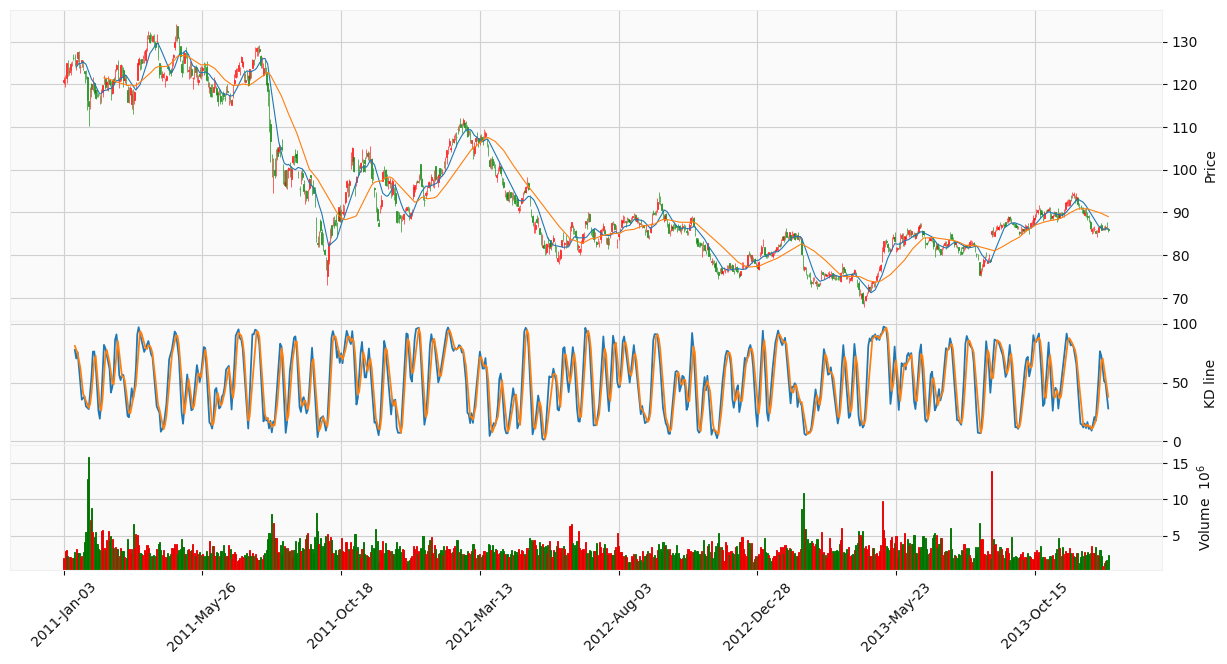

In [10]:
mpf.plot(data_df, type='candle', mav=(10,30), addplot=[kd_line_plot], volume=True, figsize=(16,8), volume_panel=2, style=s)

### Q2 : Data Preprocessing

In [11]:
mav10 = data_df["Close"].rolling(10).mean()
mav30 = data_df["Close"].rolling(30).mean()

In [12]:
data_df.insert(6, "mav10", mav10)
data_df.insert(7, "mav30", mav30)
data_df.insert(8, "%K", kd_df['slowk'])
data_df.insert(9, "%D", kd_df['slowd'])

In [13]:
original_min, original_max = data_df['Close'].min(), data_df['Close'].max()
data_df = (data_df-data_df.min())/(data_df.max()-data_df.min())
data_df

,Open,High,Low,Close,Volume,Adj Close,mav10,mav30,%K,%D
Date,,,,,,,,,,
2011-01-03,0.797490,0.806741,0.830544,0.808771,0.071071,0.801057,NaN,NaN,NaN,NaN
2011-01-04,0.815928,0.816327,0.821776,0.821633,0.132314,0.814081,NaN,NaN,NaN,NaN
2011-01-05,0.811590,0.858844,0.836282,0.868898,0.148486,0.862023,NaN,NaN,NaN,NaN
2011-01-06,0.868299,0.867965,0.860832,0.829692,0.089977,0.822197,NaN,NaN,NaN,NaN
2011-01-07,0.831732,0.843847,0.864977,0.841934,0.080508,0.834655,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2013-12-24,0.263093,0.263296,0.285350,0.269177,0.000000,0.284258,0.256014,0.301365,0.632100,0.723355
2013-12-26,0.269290,0.267471,0.286785,0.270727,0.027207,0.285768,0.255826,0.299230,0.517822,0.633490
2013-12-27,0.267586,0.271954,0.286466,0.276461,0.045078,0.291808,0.256938,0.296611,0.503234,0.552705


## Model Implementation

### config

In [53]:
batch_size = 32
n_epoch = 30000
lr = 0.008
early_stop = 200
seed = 1234
if not os.path.isdir('./models'):
    os.mkdir('./models')

In [54]:
# fix seed
def same_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seed(seed)

### Data

In [55]:
train_df = data_df[:'2012-12-31']
valid_df = data_df.loc['2013-01-01':'2013-06-30']
test_df = data_df['2013-07-01':]

In [56]:
class StockPriceDataset(Dataset):
    def __init__(self, data_df):
        self.x = [data_df.iloc[i:i+30].values for i in range(30, len(data_df)-30)]
        self.y = data_df['Close'].values[60:]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return len(self.x)

In [57]:
train_dataset = StockPriceDataset(train_df)
valid_dataset = StockPriceDataset(valid_df)
test_dataset = StockPriceDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

### Q3, 4, 5 : RNN Model

In [58]:
rnn_model_path = "./models/rnn.ckpt"

In [59]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size=20, num_layers=1, batch_first=True, nonlinearity='tanh'):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                          batch_first=batch_first, nonlinearity=nonlinearity)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:,-1,:]).view(-1)
        out = torch.sigmoid(out)
        return out

In [60]:
criterion = nn.MSELoss()
rnn = VanillaRNN(input_size=10, hidden_size=20, num_layers=1, batch_first=True)    # vanilla RNN
optimizer = torch.optim.SGD(rnn.parameters(), lr=lr, momentum=0.9, nesterov=True)
# optimizer = torch.optim.Adagrad(rnn.parameters(), lr=lr, lr_decay=0, weight_decay=0)
rnn.train().to(device)
rnn_train_loss_list, rnn_valid_loss_list = [], []
lowest_loss, early_stop_count = float("inf"), 0
for epoch in range(n_epoch):
    train_loss, valid_loss = 0, 0
    for x, y in train_loader:
        optimizer.zero_grad()
        x, y = x.float().to(device), y.float().to(device)
        output = rnn(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()
    train_loss = train_loss/len(train_loader)
    rnn_train_loss_list.append(train_loss)
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.float().to(device), y.float().to(device)
            output = rnn(x)
            loss = criterion(y, output)
            valid_loss += loss.detach().item()
        valid_loss = valid_loss/len(valid_loader)
        rnn_valid_loss_list.append(valid_loss)
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            early_stop_count = 0
            torch.save(rnn.state_dict(), rnn_model_path)
            print(f"Save model at epoch {epoch+1} with valid loss = {valid_loss}")
        else:
            early_stop_count += 1
        
        if early_stop_count >= early_stop:
            print(f'Model is not improving, early stop at epoch {epoch+1}.')
            break

    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{n_epoch}] : Train Loss : {train_loss}, Valid Loss : {valid_loss}')

Streaming output truncated to the last 5000 lines.
Save model at epoch 398 with valid loss = 0.002236927190097049
Save model at epoch 399 with valid loss = 0.0022359866852639243
Save model at epoch 400 with valid loss = 0.002235049629234709
Epoch [400/30000] : Train Loss : 0.0016408440361764015, Valid Loss : 0.002235049629234709
Save model at epoch 401 with valid loss = 0.002234116807812825
Save model at epoch 402 with valid loss = 0.0022331863292492926
Save model at epoch 403 with valid loss = 0.0022322598815662786
Save model at epoch 404 with valid loss = 0.0022313361696433276
Save model at epoch 405 with valid loss = 0.002230415091617033
Save model at epoch 406 with valid loss = 0.002229498539236374
Save model at epoch 407 with valid loss = 0.002228584489785135
Save model at epoch 408 with valid loss = 0.002227673801826313
Save model at epoch 409 with valid loss = 0.0022267658641794696
Save model at epoch 410 with valid loss = 0.0022258616954786703
Epoch [410/30000] : Train Loss : 0

[]

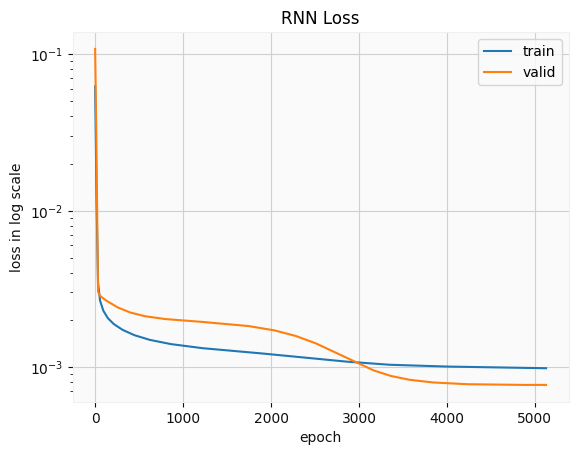

In [61]:
plt.title("RNN Loss")
plt.xlabel("epoch")
plt.ylabel("loss in log scale")
plt.yscale("log")
plt.plot(rnn_train_loss_list, label="train")
plt.plot(rnn_valid_loss_list, label="valid")
plt.legend()
plt.plot()

In [62]:
rnn = VanillaRNN(input_size=10, hidden_size=20, num_layers=1, batch_first=True)
rnn.load_state_dict(torch.load(rnn_model_path))
rnn.eval().to(device)
rnn_test_loss, rnn_test_pred = 0, []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.float().to(device), y.float().to(device)
        output = rnn(x)
        loss = criterion(output, y)
        rnn_test_loss += loss.detach().item()
        rnn_test_pred += output.tolist()
    test_loss = rnn_test_loss/len(test_loader)
    print(f"test loss : {test_loss}")

test loss : 0.00017570525233168155


In [63]:
original_rnn_test_pred = np.array(rnn_test_pred) * (original_max - original_min) + original_min
original_test_price = test_dataset.y * (original_max - original_min) + original_min

[]

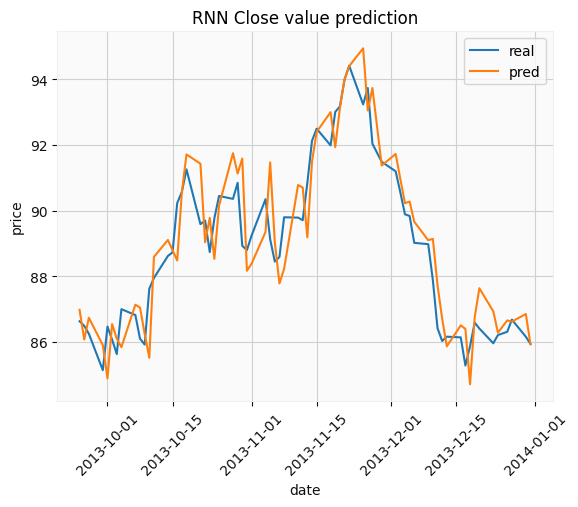

In [64]:
plt.title("RNN Close value prediction")
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45)
plt.plot(test_df.index[60:], original_test_price, label="real")
plt.plot(test_df.index[60:], original_rnn_test_pred, label="pred")
plt.legend()
plt.plot()

### Q6 : LSTM

In [65]:
lstm_model_path = "models/lstm.ckpt"

In [66]:
class VanillaLSTM(nn.Module):
    def __init__(self, input_size=10, hidden_size=20, num_layers=1, batch_first=True):
        super(VanillaLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                            batch_first=batch_first)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:,-1,:]).view(-1)
        out = torch.sigmoid(out)
        return out

In [67]:
criterion = nn.MSELoss()
lstm = VanillaLSTM(input_size=10, hidden_size=20, num_layers=1, batch_first=True)    # vanilla LSTM
optimizer = torch.optim.SGD(lstm.parameters(), lr=lr, momentum=0.9, nesterov=True)
# optimizer = torch.optim.Adagrad(rnn.parameters(), lr=lr, lr_decay=0, weight_decay=0)
# optimizer = torch.optim.RMSprop(rnn.parameters(), lr=lr, weight_decay=0)
lstm.train().to(device)
lstm_train_loss_list, lstm_valid_loss_list = [], []
lowest_loss, early_stop_count = float("inf"), 0
for epoch in range(n_epoch):
    train_loss, valid_loss = 0, 0
    for x, y in train_loader:
        optimizer.zero_grad()
        x, y = x.float().to(device), y.float().to(device)
        output = lstm(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()
    train_loss = train_loss/len(train_loader)
    lstm_train_loss_list.append(train_loss)
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.float().to(device), y.float().to(device)
            output = lstm(x)
            loss = criterion(y, output)
            valid_loss += loss.detach().item()
        valid_loss = valid_loss/len(valid_loader)
        lstm_valid_loss_list.append(valid_loss)
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            early_stop_count = 0
            torch.save(lstm.state_dict(), lstm_model_path)
            print(f"Save model at epoch {epoch+1} with valid loss = {valid_loss}")
        else:
            early_stop_count += 1
        
        if early_stop_count >= early_stop:
            print(f'Model is not improving, early stop at epoch {epoch+1}.')
            break

    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{n_epoch}] : Train Loss : {train_loss}, Valid Loss : {valid_loss}')

Streaming output truncated to the last 5000 lines.
Save model at epoch 13147 with valid loss = 0.0008545178279746324
Save model at epoch 13148 with valid loss = 0.0008545138116460294
Save model at epoch 13149 with valid loss = 0.0008545097662135959
Save model at epoch 13150 with valid loss = 0.0008545058080926538
Epoch [13150/30000] : Train Loss : 0.0009659326772504885, Valid Loss : 0.0008545058080926538
Save model at epoch 13151 with valid loss = 0.0008545017626602203
Save model at epoch 13152 with valid loss = 0.000854497542604804
Save model at epoch 13153 with valid loss = 0.0008544937008991838
Save model at epoch 13154 with valid loss = 0.0008544895681552589
Save model at epoch 13155 with valid loss = 0.0008544854645151645
Save model at epoch 13156 with valid loss = 0.0008544813608750701
Save model at epoch 13157 with valid loss = 0.000854477402754128
Save model at epoch 13158 with valid loss = 0.0008544735610485077
Save model at epoch 13159 with valid loss = 0.0008544695447199047


[]

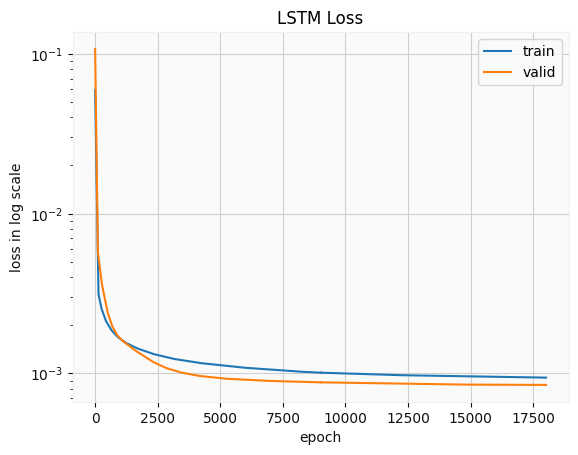

In [68]:
plt.title("LSTM Loss")
plt.xlabel("epoch")
plt.ylabel("loss in log scale")
plt.yscale("log")
plt.plot(lstm_train_loss_list, label="train")
plt.plot(lstm_valid_loss_list, label="valid")
plt.legend()
plt.plot()

In [69]:
lstm = VanillaLSTM(input_size=10, hidden_size=20, num_layers=1, batch_first=True)
lstm.load_state_dict(torch.load(lstm_model_path))
lstm.eval().to(device)
lstm_test_loss, lstm_test_pred = 0, []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.float().to(device), y.float().to(device)
        output = lstm(x)
        loss = criterion(output, y)
        lstm_test_loss += loss.detach().item()
        lstm_test_pred += output.tolist()
    lstm_test_loss = lstm_test_loss/len(test_loader)
    print(f"test loss : {lstm_test_loss}")

test loss : 0.00022501850132054338


In [70]:
original_lstm_test_pred = np.array(lstm_test_pred) * (original_max - original_min) + original_min

[]

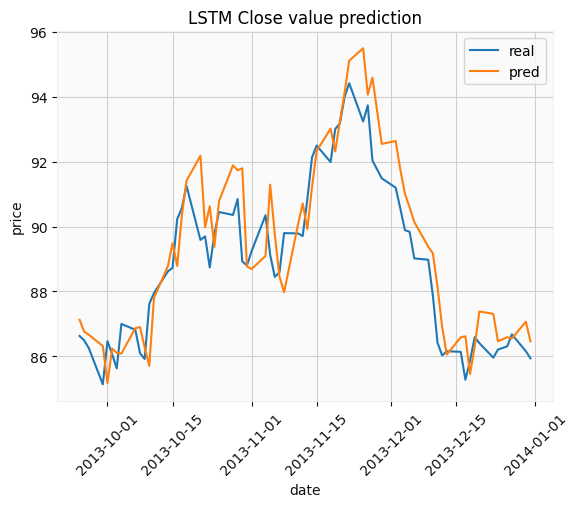

In [71]:
plt.title("LSTM Close value prediction")
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45)
plt.plot(test_df.index[60:], original_test_price, label="real")
plt.plot(test_df.index[60:], original_lstm_test_pred, label="pred")
plt.legend()
plt.plot()

### Q7 : GRU

In [72]:
gru_model_path = "models/gru.ckpt"

In [73]:
class VanillaGRU(nn.Module):
    def __init__(self, input_size=10, hidden_size=20, num_layers=1, batch_first=True):
        super(VanillaGRU, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                          batch_first=batch_first)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:,-1,:]).view(-1)
        out = torch.sigmoid(out)
        return out

In [74]:
criterion = nn.MSELoss()
gru = VanillaGRU(input_size=10, hidden_size=20, num_layers=1, batch_first=True)    # vanilla GRU
optimizer = torch.optim.SGD(gru.parameters(), lr=lr, momentum=0.9, nesterov=True)
# optimizer = torch.optim.Adagrad(rnn.parameters(), lr=lr, lr_decay=0, weight_decay=0)
# optimizer = torch.optim.RMSprop(rnn.parameters(), lr=lr, weight_decay=0)
gru.train().to(device)
gru_train_loss_list, gru_valid_loss_list = [], []
lowest_loss, early_stop_count = float("inf"), 0
for epoch in range(n_epoch):
    train_loss, valid_loss = 0, 0
    for x, y in train_loader:
        optimizer.zero_grad()
        x, y = x.float().to(device), y.float().to(device)
        output = gru(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()
    train_loss = train_loss/len(train_loader)
    gru_train_loss_list.append(train_loss)
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.float().to(device), y.float().to(device)
            output = gru(x)
            loss = criterion(y, output)
            valid_loss += loss.detach().item()
        valid_loss = valid_loss/len(valid_loader)
        gru_valid_loss_list.append(valid_loss)
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            early_stop_count = 0
            torch.save(gru.state_dict(), gru_model_path)
            print(f"Save model at epoch {epoch+1} with valid loss = {valid_loss}")
        else:
            early_stop_count += 1
        
        if early_stop_count >= early_stop:
            print(f'Model is not improving, early stop at epoch {epoch+1}.')
            break

    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{n_epoch}] : Train Loss : {train_loss}, Valid Loss : {valid_loss}')

Streaming output truncated to the last 5000 lines.
Save model at epoch 17277 with valid loss = 0.0006660762301180512
Save model at epoch 17278 with valid loss = 0.0006660729413852096
Save model at epoch 17279 with valid loss = 0.0006660694052698091
Save model at epoch 17280 with valid loss = 0.0006660663784714416
Epoch [17280/30000] : Train Loss : 0.0009438528421534491, Valid Loss : 0.0006660663784714416
Save model at epoch 17281 with valid loss = 0.000666062711388804
Save model at epoch 17282 with valid loss = 0.0006660591752734035
Save model at epoch 17283 with valid loss = 0.0006660557410214096
Save model at epoch 17284 with valid loss = 0.0006660521758021787
Save model at epoch 17285 with valid loss = 0.0006660488725174218
Save model at epoch 17286 with valid loss = 0.0006660456565441564
Save model at epoch 17287 with valid loss = 0.0006660421786364168
Save model at epoch 17288 with valid loss = 0.0006660387443844229
Save model at epoch 17289 with valid loss = 0.0006660354556515813

[]

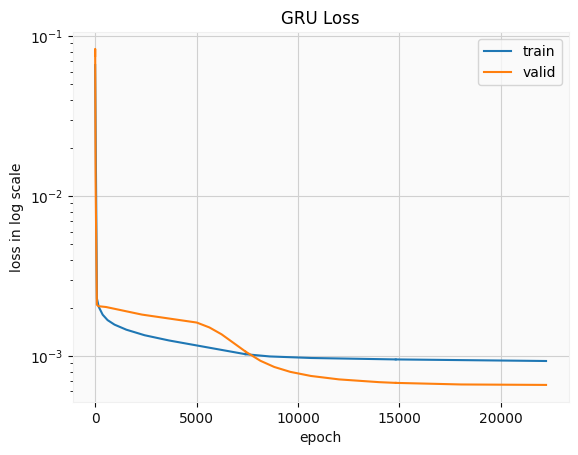

In [75]:
plt.title("GRU Loss")
plt.xlabel("epoch")
plt.ylabel("loss in log scale")
plt.yscale("log")
plt.plot(gru_train_loss_list, label="train")
plt.plot(gru_valid_loss_list, label="valid")
plt.legend()
plt.plot()

In [76]:
gru = VanillaGRU(input_size=10, hidden_size=20, num_layers=1, batch_first=True)
gru.load_state_dict(torch.load(gru_model_path))
gru.eval().to(device)
gru_test_loss, gru_test_pred = 0, []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.float().to(device), y.float().to(device)
        output = gru(x)
        loss = criterion(output, y)
        gru_test_loss += loss.detach().item()
        gru_test_pred += output.tolist()
    gru_test_loss = gru_test_loss/len(test_loader)
    print(f"test loss : {gru_test_loss}")

test loss : 0.00019928019416208068


In [77]:
original_gru_test_pred = np.array(gru_test_pred) * (original_max - original_min) + original_min

[]

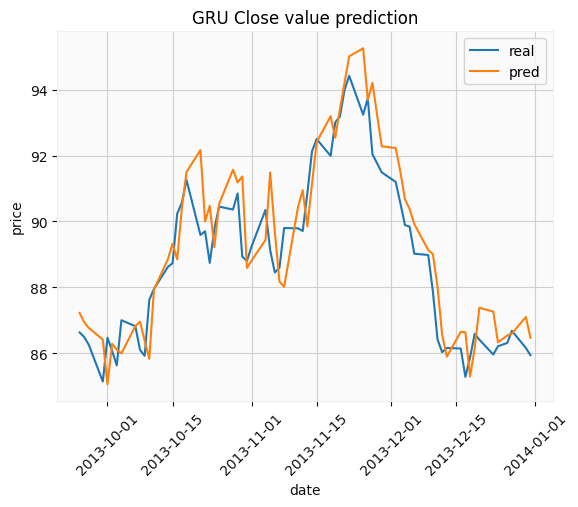

In [78]:
plt.title("GRU Close value prediction")
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45)
plt.plot(test_df.index[60:], original_test_price, label="real")
plt.plot(test_df.index[60:], original_gru_test_pred, label="pred")
plt.legend()
plt.plot()

## Bonus

news data : length = 5357
- Tickers: Stock symbol *Apple Inc. (AAPL)
- Date: Published date (from '2011-02-14' to '2013-11-26')
- Title: Headline of the news
- Content: Content of the news

### load news data

In [79]:
news_path = os.path.join(data_dir, "APPLE_news.pkl")
with open(news_path, 'rb') as f:
    news_list = pickle.load(f)
news_df = pd.DataFrame(news_list, columns=["Tickers", "Date", "Title", "Content"])
news_df["Content"] = news_df["Title"] + " " + news_df["Content"]
news_df = news_df.drop(columns=["Title"])
news_df = news_df.rename(columns={"Content": "Title-Content"})
news_df.head(3)

,Tickers,Date,Title-Content
0,"[C, AAPL, GOOG]",2011-02-14,pandora sales more than double ahead of ipo pa...
1,"[GOOG, 6758, CMCSA, TWX, AAPL, LGF, NWSA, DIS]",2011-02-27,youtube said to plan movie rentals from sony u...
2,"[VSEA, PBH, ADBE, AAPL, FDO, GOOG, MAKO, MBI, ...",2011-03-01,amazoncom apple google nyse euronext us equity...


### load pre-trained BERT

In [80]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 24.8 MB/s 
     |████████████████████████████████| 163 kB 66.7 MB/s 
     |████████████████████████████████| 7.6 MB 57.7 MB/s 


In [81]:
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased").to(device)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [83]:
batch_size = 8
total_embedding = []
for epoch in tqdm(range(0,(len(news_df)//batch_size)+1)):
    start = epoch * batch_size
    if epoch != len(news_df)//batch_size:
        end = start + batch_size
    else:
        end = len(news_df)
    tokenized = tokenizer(news_df["Title-Content"][start:end].tolist(), return_tensors='pt', padding="max_length", truncation=True)
    tokenized = tokenized.to(device)
    embedding = model(**tokenized)
    tokenized.to("cpu")
    total_embedding += embedding[1].tolist()

100%|██████████| 670/670 [05:02<00:00,  2.21it/s]


In [84]:
# torch.cuda.empty_cache()
!nvidia-smi

Tue Nov  1 03:28:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    38W /  70W |   9022MiB / 15109MiB |     79%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### get pre-trained embedding

In [85]:
total_embedding = [np.array(emb) for emb in total_embedding]

In [86]:
temp_df = pd.DataFrame({"Date":news_df["Date"], "embedding":total_embedding})
date_embed_dict = temp_df.groupby(["Date"]).mean().T.to_dict()

In [87]:
news_embedding_array = np.empty([754, 768])
for i, datetime in enumerate(data_df.index):
    date = str(datetime.date())
    if date in date_embed_dict:
        news_embedding_array[i] = date_embed_dict[date]['embedding']
    else:
        news_embedding_array[i] = [0] * 768

In [88]:
new_data_df = data_df.copy()
for col in range(0, 768):
    new_data_df.insert(col+10, f"embed_{col}", news_embedding_array[:,col])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


### Data

In [89]:
train_df = new_data_df[:'2012-12-31']
valid_df = new_data_df['2013-01-01':'2013-06-30']
test_df = new_data_df['2013-07-01':]

In [90]:
class StockPriceDataset(Dataset):
    def __init__(self, data_df):
        self.x = [data_df.iloc[i:i+30].values for i in range(30, len(data_df)-30)]
        self.y = data_df['Close'].values[60:]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return len(self.x)

In [91]:
train_dataset = StockPriceDataset(train_df)
valid_dataset = StockPriceDataset(valid_df)
test_dataset = StockPriceDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

### RNN Model

In [92]:
rnn_model_path = "./models/news_rnn.ckpt"

In [93]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size=778, hidden_size=20, num_layers=1, batch_first=True, nonlinearity='tanh'):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                          batch_first=batch_first, nonlinearity=nonlinearity)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, hn = self.rnn(x)
        out = self.fc(out[:,-1,:]).view(-1)
        out = torch.sigmoid(out)
        return out

In [94]:
criterion = nn.MSELoss()
rnn = VanillaRNN(input_size=778, hidden_size=20, num_layers=1, batch_first=True)    # vanilla RNN
optimizer = torch.optim.SGD(rnn.parameters(), lr=lr, momentum=0.9, nesterov=True)
# optimizer = torch.optim.Adagrad(rnn.parameters(), lr=lr, lr_decay=0, weight_decay=0)
rnn.train().to(device)
rnn_train_loss_list, rnn_valid_loss_list = [], []
lowest_loss, early_stop_count = float("inf"), 0
for epoch in range(n_epoch):
    train_loss, valid_loss = 0, 0
    for x, y in train_loader:
        optimizer.zero_grad()
        x, y = x.float().to(device), y.float().to(device)
        output = rnn(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()
    train_loss = train_loss/len(train_loader)
    rnn_train_loss_list.append(train_loss)
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.float().to(device), y.float().to(device)
            output = rnn(x)
            loss = criterion(y, output)
            valid_loss += loss.detach().item()
        valid_loss = valid_loss/len(valid_loader)
        rnn_valid_loss_list.append(valid_loss)
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            early_stop_count = 0
            torch.save(rnn.state_dict(), rnn_model_path)
            print(f"Save model at epoch {epoch+1} with valid loss = {valid_loss}")
        else:
            early_stop_count += 1
        
        if early_stop_count >= early_stop:
            print(f'Model is not improving, early stop at epoch {epoch+1}.')
            break

    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{n_epoch}] : Train Loss : {train_loss}, Valid Loss : {valid_loss}')

Save model at epoch 1 with valid loss = 0.009459975870413473
Save model at epoch 2 with valid loss = 0.008230716317484621
Epoch [10/30000] : Train Loss : 0.08066017935561831, Valid Loss : 0.009723821833176771
Epoch [20/30000] : Train Loss : 0.07801382672654913, Valid Loss : 0.009878668388410006
Epoch [30/30000] : Train Loss : 0.07382749243801559, Valid Loss : 0.009854203264694661
Epoch [40/30000] : Train Loss : 0.06993583715458433, Valid Loss : 0.009546656634483952
Epoch [50/30000] : Train Loss : 0.06913638205774728, Valid Loss : 0.00978950100397924
Epoch [60/30000] : Train Loss : 0.07606428654928875, Valid Loss : 0.010385477897216333
Epoch [70/30000] : Train Loss : 0.06564093051656528, Valid Loss : 0.008675720790051855
Epoch [80/30000] : Train Loss : 0.07562564789986936, Valid Loss : 0.0093780144561606
Save model at epoch 90 with valid loss = 0.0071743432054063305
Epoch [90/30000] : Train Loss : 0.07354699402432223, Valid Loss : 0.0071743432054063305
Epoch [100/30000] : Train Loss : 0

[]

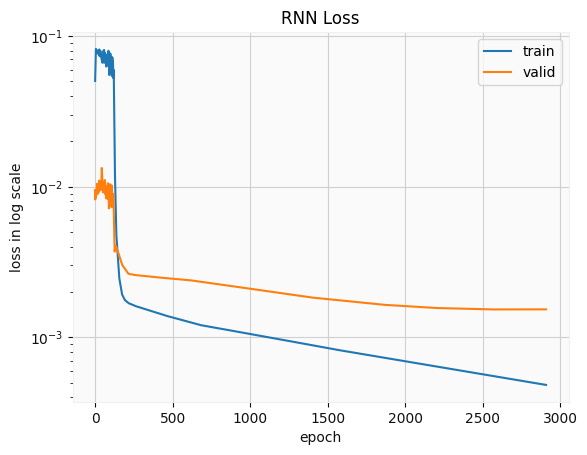

In [95]:
plt.title("RNN Loss")
plt.xlabel("epoch")
plt.ylabel("loss in log scale")
plt.yscale("log")
plt.plot(rnn_train_loss_list, label="train")
plt.plot(rnn_valid_loss_list, label="valid")
plt.legend()
plt.plot()

In [96]:
rnn = VanillaRNN(input_size=778, hidden_size=20, num_layers=1, batch_first=True)
rnn.load_state_dict(torch.load(rnn_model_path))
rnn.eval().to(device)
rnn_test_loss, rnn_test_pred = 0, []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.float().to(device), y.float().to(device)
        output = rnn(x)
        loss = criterion(output, y)
        rnn_test_loss += loss.detach().item()
        rnn_test_pred += output.tolist()
    test_loss = rnn_test_loss/len(test_loader)
    print(f"test loss : {test_loss}")

test loss : 0.00197647862498545


In [97]:
original_rnn_test_pred = np.array(rnn_test_pred) * (original_max - original_min) + original_min

[]

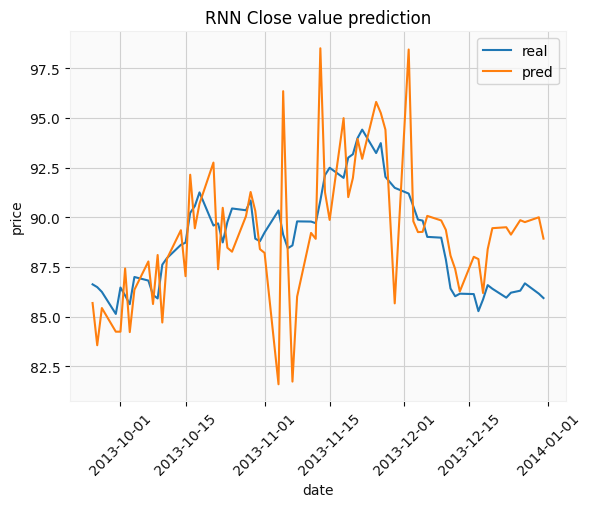

In [98]:
plt.title("RNN Close value prediction")
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45)
plt.plot(test_df.index[60:], original_test_price, label="real")
plt.plot(test_df.index[60:], original_rnn_test_pred, label="pred")
plt.legend()
plt.plot()